<a href="https://www.kaggle.com/code/alkaifansari000/us-congress-socail-network-analysis?scriptVersionId=235089848" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import ast
import json
import random
import numpy
import warnings
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from community import community_louvain
from sklearn.metrics import roc_auc_score


In [2]:
sns.set()
warnings.filterwarnings('ignore')  # Ignore all warnings

## Edge List

In [3]:
# Custom function to parse your specific format
def load_custom_edgelist(path):
    G = nx.Graph()
    with open(path, 'r') as f:
        for line in f:
            # Split into components
            parts = line.strip().split()
            if len(parts) < 3:
                continue  # Skip malformed lines
                
            u, v = parts[0], parts[1]
            attr_str = ' '.join(parts[2:])  # Combine remaining parts
            
            # Safely evaluate the dictionary string
            try:
                attrs = ast.literal_eval(attr_str)
                if 'weight' in attrs:
                    G.add_edge(u, v, weight=float(attrs['weight']))
            except:
                print(f"Skipping malformed line: {line}")
    return G

In [4]:
# Load the graph
G = load_custom_edgelist("/kaggle/input/us-congress-edgelist/congress.edgelist")

# Verify
print(f"Loaded graph with {len(G.nodes())} nodes and {len(G.edges())} edges")
print("Sample edge:", list(G.edges(data=True))[0])

Loaded graph with 475 nodes and 10222 edges
Sample edge: ('0', '4', {'weight': 0.0036496350364963502})


In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G)}")
print(f"Is connected: {nx.is_connected(G)}")

# List some nodes and edges (limited to first 5 to avoid overwhelming output)
print(f"\nSample nodes: {list(G.nodes())[:5]}")
print(f"Sample edges: {list(G.edges())[:5]}")

# Get degree information
degrees = [d for n, d in G.degree()]
print(f"\nAverage degree: {sum(degrees)/len(degrees):.2f}")
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")

Number of nodes: 475
Number of edges: 10222
Graph density: 0.09080168776371308
Is connected: True

Sample nodes: ['0', '4', '12', '18', '25']
Sample edges: [('0', '4'), ('0', '12'), ('0', '18'), ('0', '25'), ('0', '30')]

Average degree: 43.04
Min degree: 2
Max degree: 214


## Meta Data

In [6]:
with open("/kaggle/input/us-congress-metadata/congress_network_data.json") as f:
    metadata = json.load(f)  # Expected format: {"0": {"party": "D", "name": "Senator X"}, ...}

# Add metadata to nodes (if available)
for node in G.nodes():
    if node in metadata:
        G.nodes[node].update(metadata[node])

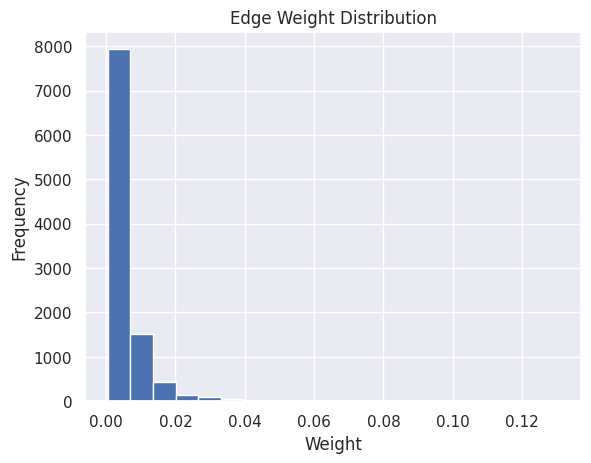

In [7]:
weights = [d["weight"] for _, _, d in G.edges(data=True)]
plt.hist(weights, bins=20)
plt.title("Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

## Compute Centrality Measures & Compare with PageRank

In [8]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, weight="weight")

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G, distance="weight")  # Use weight as distance

# Eigenvector Centrality with increased max_iter and relaxed tolerance
try:
    eigenvector_centrality = nx.eigenvector_centrality(G, weight="weight", max_iter=1000, tol=1e-4)
except nx.PowerIterationFailedConvergence:
    print("Warning: Eigenvector centrality failed to converge. Using alternative method...")
    # Alternative approach: use scipy's sparse eigenvalue solver
    import numpy as np
    import scipy.sparse as sp
    import scipy.sparse.linalg as spla
    
    # Create adjacency matrix
    A = nx.to_scipy_sparse_array(G, weight="weight")
    # Normalize the matrix
    n = A.shape[0]
    try:
        eigenvalues, eigenvectors = spla.eigs(A, k=1, which="LM")
        # Get the eigenvector corresponding to the largest eigenvalue
        largest_eigenvector = np.abs(eigenvectors[:, 0])
        # Normalize the eigenvector
        largest_eigenvector = largest_eigenvector / largest_eigenvector.sum()
        # Create a dictionary of node to centrality value
        eigenvector_centrality = {node: float(largest_eigenvector[i]) 
                                 for i, node in enumerate(G.nodes())}
    except:
        print("Alternative eigenvector method also failed. Skipping eigenvector centrality.")
        eigenvector_centrality = {node: 0.0 for node in G.nodes()}

# PageRank (Baseline) - also increase max_iter
pagerank = nx.pagerank(G, weight="weight", max_iter=200)

## Rank Nodes by Each Metric

In [9]:
# Create a DataFrame of centrality scores
centrality_df = pd.DataFrame({
    "Degree": degree_centrality,
    "Betweenness": betweenness_centrality,
    "Closeness": closeness_centrality,
    "Eigenvector": eigenvector_centrality,
    "PageRank": pagerank
})

# Rank nodes (1 = highest centrality)
rank_df = centrality_df.rank(ascending=False)
print(rank_df.head(10))  # Top-10 nodes by each metric

    Degree  Betweenness  Closeness  Eigenvector  PageRank
0    281.0        283.0      248.0        452.0     336.0
4    173.5         71.0       79.0        456.0     341.0
12   192.0        120.0      186.0        138.0      40.0
18   289.0        105.0       24.0        464.0     327.0
25    96.0         46.0       53.0        345.0     208.0
30   112.5         75.0       72.0        219.0     246.0
46    96.0        191.0       61.0        278.0      79.0
55   120.0        101.0       89.0        280.0      52.0
58    96.0         18.0       14.0        360.0     160.0
59   108.5         34.0      104.0        408.0     230.0


## Compute Rank Correlation (Spearman)

In [10]:
# Compare PageRank with other metrics
correlation_results = {}
for col in rank_df.columns:
    if col != "PageRank":
        corr, p_value = spearmanr(rank_df["PageRank"], rank_df[col])
        correlation_results[col] = corr

print("Rank Correlation with PageRank:")
print(pd.Series(correlation_results))

Rank Correlation with PageRank:
Degree         0.816529
Betweenness    0.370170
Closeness      0.323132
Eigenvector    0.660418
dtype: float64


## Apply Graph Mining Techniques

In [11]:
# Detect communities
partition = community_louvain.best_partition(G, weight="weight")

# Add community labels to nodes
nx.set_node_attributes(G, partition, "community")

# Count communities
import numpy as np
print(f"Detected {np.unique(list(partition.values())).size} communities")

# Optional: Visualize (if metadata has party labels)
if "party" in list(G.nodes(data=True))[0][1]:
    nx.draw(G, node_color=[G.nodes[n]["party"] for n in G.nodes()], with_labels=False)
    plt.show()

Detected 5 communities


## Link Prediction (Adamic-Adar Index)

In [12]:
# Generate non-existent edges (negative samples)
non_edges = random.sample(list(nx.non_edges(G)), k=1000)  # Sample 1000 fake edges

# Compute Adamic-Adar scores for real and fake edges
real_edges = list(G.edges())[:1000]  # Take first 1000 real edges

# The issue is with how we're using adamic_adar_index
# It expects ebunch as [(u,v), (u,v), ...] not [[u,v], [u,v], ...]
real_scores = []
for u, v in real_edges:
    # Get the first (and only) tuple from the generator
    for u2, v2, score in nx.adamic_adar_index(G, [(u, v)]):
        real_scores.append(score)
        break

fake_scores = []
for u, v in non_edges:
    for u2, v2, score in nx.adamic_adar_index(G, [(u, v)]):
        fake_scores.append(score)
        break

# Evaluate with AUC-ROC
y_true = [1] * len(real_scores) + [0] * len(fake_scores)
y_score = real_scores + fake_scores
auc = roc_auc_score(y_true, y_score)
print(f"Adamic-Adar AUC: {auc:.3f}")

Adamic-Adar AUC: 0.886


##  Community Structure Visualization

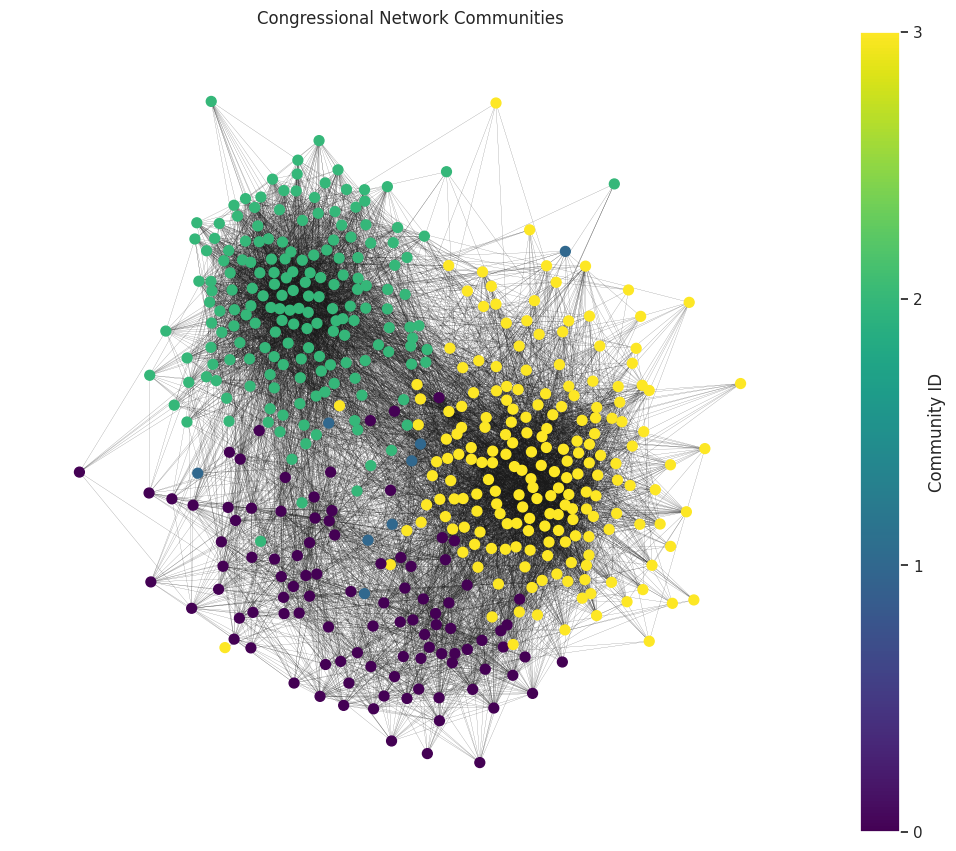

In [13]:

import numpy as np

# Detect communities
partition = community_louvain.best_partition(G, weight='weight')

# Get number of communities
num_communities = max(partition.values()) + 1

# Setup the figure
plt.figure(figsize=(10, 8))

# Use updated colormap syntax to avoid deprecation warning
cmap = plt.colormaps['viridis']

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_communities-1))
sm.set_array([])  # This is needed for the colorbar to work

# Draw the network with spring layout
pos = nx.spring_layout(G, seed=42)  # Added seed for reproducibility
nx.draw(G, 
       pos=pos,
       node_color=[partition[node] for node in G.nodes()], 
       cmap=cmap,
       node_size=50,
       width=0.1,
       with_labels=False)

plt.title("Congressional Network Communities")

# Add the colorbar using the ScalarMappable
cbar = plt.colorbar(sm, ticks=range(num_communities), label="Community ID")

plt.axis('off')
plt.tight_layout()
plt.show()

## Centrality Heatmap

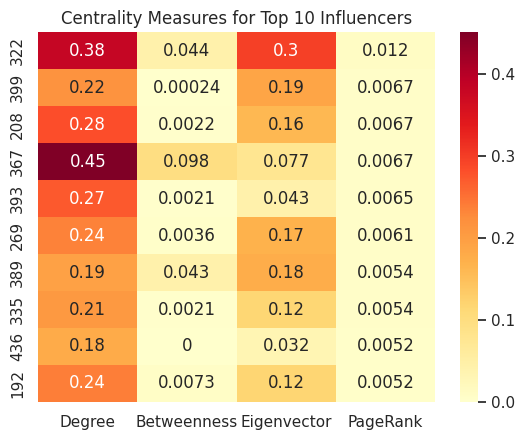

In [14]:
# Get top 10 nodes by PageRank
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
node_ids = [n[0] for n in top_nodes]

# Create comparison dataframe
centrality_comparison = pd.DataFrame({
    'Degree': [degree_centrality[n] for n in node_ids],
    'Betweenness': [betweenness_centrality[n] for n in node_ids],
    'Eigenvector': [eigenvector_centrality[n] for n in node_ids],
    'PageRank': [pagerank[n] for n in node_ids]
}, index=node_ids)

# Plot
sns.heatmap(centrality_comparison, annot=True, cmap="YlOrRd")
plt.title("Centrality Measures for Top 10 Influencers")
plt.show()

## Weight Distribution Analysis

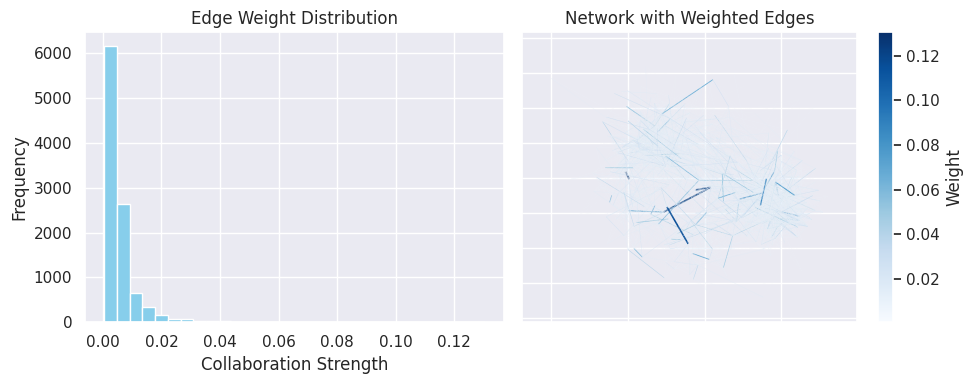

In [15]:
plt.figure(figsize=(10, 4))

# First subplot - Histogram
plt.subplot(1, 2, 1)
weights = [d['weight'] for _, _, d in G.edges(data=True)]
plt.hist(weights, bins=30, color='skyblue')
plt.title("Edge Weight Distribution")
plt.xlabel("Collaboration Strength")
plt.ylabel("Frequency")

# Second subplot - Network graph
plt.subplot(1, 2, 2)
pos = nx.spring_layout(G)
# Create a mappable object for the colorbar
edges = nx.draw_networkx_edges(
    G, 
    pos=pos,
    node_size=0,
    width=[w*10 for w in weights],  # Scale for visibility
    edge_color=weights,
    edge_cmap=plt.cm.Blues
)
plt.title("Network with Weighted Edges")

# Create colorbar from the edges mappable
plt.colorbar(edges, label="Weight")

plt.tight_layout()
plt.show()